## 1. Getting/cleaning data

Load BBB and ChEMBl data into pandas dataframes. 

The BBB dataset was provided by my cheminformatics professor. Melatonin receptor ligands were downloaded from https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL1946/.

In [1]:
import pandas as pd

bbb = pd.read_csv("/Users/jennyflax/RBIF110/RBIF110week5/Week5_BBB_Data.txt", 
                  sep="\t", usecols=["name", "p_np", "smiles"], encoding="latin1")
mel = pd.read_csv("/Users/jennyflax/RBIF110/RBIF110week6/ChEMBL_MelatoninReceptor_Activities.csv", 
                  sep=";", usecols=["Molecule ChEMBL ID", "Molecule Name", "Smiles"])
mel.head()

,Molecule ChEMBL ID,Molecule Name,Smiles
0,CHEMBL563847,NaN,COc1ccc2[nH]c(CN(C)c3ccc(C(F)(F)F)cc3)c(CCNC(C...
1,CHEMBL556908,NaN,CCCC(=O)NCCc1c2n(c3ccc(OC)cc13)CCN(C)C2
2,CHEMBL286814,NaN,COc1cccc2[nH]cc(CCNC(C)=O)c12
3,CHEMBL287339,NaN,O=C(NCCc1c(Br)[nH]c2ccccc12)C1CCC1
4,CHEMBL45,MELATONIN,COc1ccc2[nH]cc(CCNC(C)=O)c2c1


Strip salts and calculate molecular descriptors with RDKit.

In [2]:
from rdkit import Chem
from rdkit.Chem import SaltRemover, Descriptors, Lipinski, rdMolDescriptors

# Initialize the salt remover; salt definitions are in salts.txt
remover = SaltRemover.SaltRemover(defnFilename="/Users/jennyflax/salts.txt")

def calculate_descriptors(smiles):
    # Convert SMILES to an RDKit molecule
    mol = Chem.MolFromSmiles(smiles)
    
    if mol is not None:
        # Strip salts from the molecule
        mol_nosalt = remover.StripMol(mol)
        
        # Calculate descriptors of interest for the salt-stripped molecule
        mw = Descriptors.ExactMolWt(mol_nosalt)
        logp = Descriptors.MolLogP(mol_nosalt)
        tpsa = Descriptors.TPSA(mol_nosalt)
        hba = Descriptors.NumHAcceptors(mol_nosalt)
        hbd = Descriptors.NumHDonors(mol_nosalt)
        fcsp3 = Lipinski.FractionCSP3(mol_nosalt)
        num_rb = Lipinski.NumRotatableBonds(mol_nosalt)
        num_rings = rdMolDescriptors.CalcNumAromaticRings(mol_nosalt)
        
        return mw, logp, tpsa, hba, hbd, num_rb, fcsp3, num_rings
        
    else:
        return None, None, None, None, None # Handle cases where the SMILES string is invalid

bbb[["MW", "LogP", "tPSA", "HBA", "HBD", "FractionCSP3", "NumRotatableBonds", "NumAromaticRings"]] = bbb["smiles"].apply(lambda x: pd.Series(calculate_descriptors(x)))
mel[["MW", "LogP", "tPSA", "HBA", "HBD", "FractionCSP3", "NumRotatableBonds", "NumAromaticRings"]] = mel["Smiles"].apply(lambda x: pd.Series(calculate_descriptors(x)))

[09:42:40] Explicit valence for atom # 1 N, 4, is greater than permitted
[09:42:40] WARNING: not removing hydrogen atom without neighbors
[09:42:40] Explicit valence for atom # 6 N, 4, is greater than permitted
[09:42:40] WARNING: not removing hydrogen atom without neighbors
[09:42:40] WARNING: not removing hydrogen atom without neighbors
[09:42:40] WARNING: not removing hydrogen atom without neighbors
[09:42:40] WARNING: not removing hydrogen atom without neighbors
[09:42:40] WARNING: not removing hydrogen atom without neighbors
[09:42:40] WARNING: not removing hydrogen atom without neighbors
[09:42:40] Explicit valence for atom # 6 N, 4, is greater than permitted
[09:42:40] WARNING: not removing hydrogen atom without neighbors
[09:42:40] WARNING: not removing hydrogen atom without neighbors
[09:42:40] WARNING: not removing hydrogen atom without neighbors
[09:42:40] WARNING: not removing hydrogen atom without neighbors
[09:42:40] Explicit valence for atom # 11 N, 4, is greater than pe

### a) Overview of the known compounds (what property space do they cover)?

Calculate summary statistics for "p" (penetrating) and "n" (non-penetrating) compounds

In [3]:
mds = ["MW", "LogP", "tPSA", "HBA", "HBD", "FractionCSP3", "NumRotatableBonds", "NumAromaticRings"]
p = bbb[bbb['p_np'] == 'p']
np = bbb[bbb['p_np'] == 'n']
p[mds].describe()

,MW,LogP,tPSA,HBA,HBD,FractionCSP3,NumRotatableBonds,NumAromaticRings
count,1563.000000,1563.000000,1563.000000,1563.000000,1563.000000,1563.000000,1563.000000,1563.00000
mean,313.301836,2.759648,52.854044,3.715931,1.035189,3.798464,0.460152,1.40563
std,111.531578,1.630813,36.195119,2.137386,1.047240,2.744511,0.229280,0.96043
min,28.031300,-8.424200,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,245.177964,1.738000,29.100000,2.000000,0.000000,2.000000,0.300000,1.00000
50%,304.193949,2.845700,46.310000,3.000000,1.000000,3.000000,0.428571,1.00000
75%,379.717985,3.926610,72.830000,5.000000,2.000000,6.000000,0.619048,2.00000
max,1129.889561,10.056300,358.200000,24.000000,13.000000,27.000000,1.000000,4.00000


In [4]:
np[mds].describe()

,MW,LogP,tPSA,HBA,HBD,FractionCSP3,NumRotatableBonds,NumAromaticRings
count,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000
mean,434.184180,1.346587,125.286952,7.329854,3.156576,5.446764,0.469751,1.425887
std,210.929216,2.474701,77.407179,4.453357,2.712615,3.563645,0.237039,1.112048
min,109.052764,-8.367700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,314.182921,0.099300,69.430000,4.000000,1.000000,3.000000,0.327381,1.000000
50%,399.168188,1.349900,109.570000,6.000000,2.000000,5.000000,0.434783,1.000000
75%,494.720439,2.736670,173.590000,10.000000,4.000000,7.000000,0.584770,2.000000
max,1877.556582,10.812700,662.410000,33.000000,24.000000,35.000000,1.000000,7.000000


#### Visualize these properties as boxplots

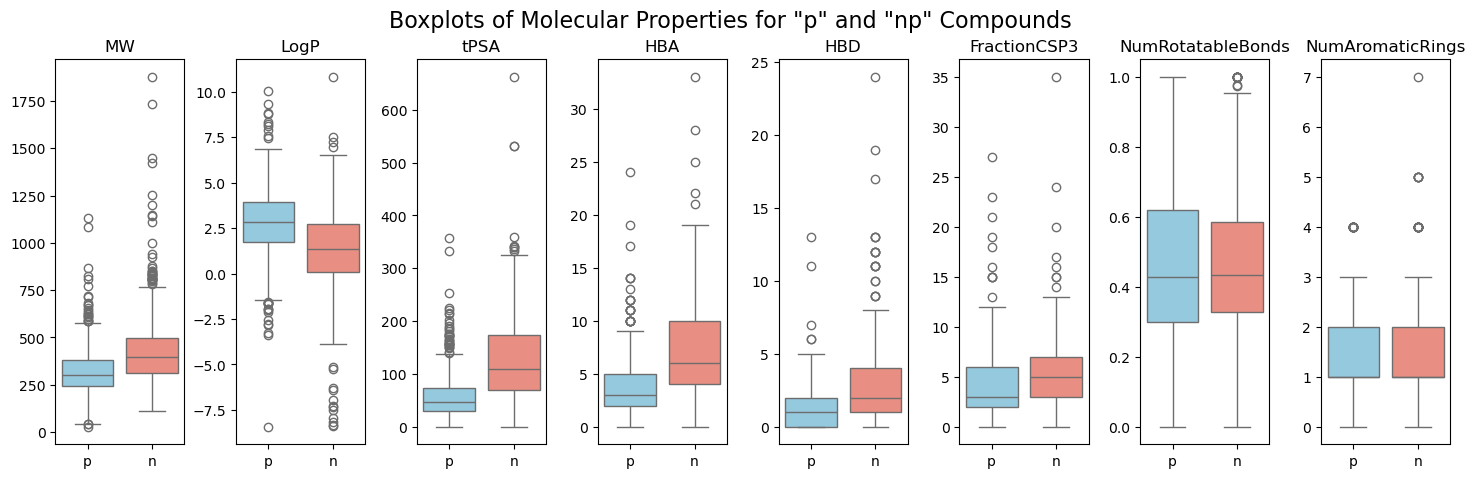

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots for combined boxplots
fig, axes = plt.subplots(1, len(mds), figsize=(18, 5))
fig.subplots_adjust(wspace=0.4)

# Create combined boxplots
for i, col in enumerate(mds):
    sns.boxplot(x='p_np', y=col, 
                data=bbb[['p_np', "MW", "LogP", "tPSA", "HBA", "HBD", "FractionCSP3", "NumRotatableBonds", "NumAromaticRings"]], 
                ax=axes[i], hue='p_np', palette=['skyblue', 'salmon'], legend=False)
    axes[i].set_title(f'{col}')
    axes[i].xaxis.set_label_text('')
    axes[i].yaxis.set_label_text('')
    
# Add an overall title
plt.suptitle('Boxplots of Molecular Properties for "p" and "n" Compounds', fontsize=16)

# Show the plot
plt.show()

FractionCSP3, NumRotatableBonds, and NumAromaticRings seem to be the most similar between penetrating and non-penetrating compounds and will be excluded from the model.

#### Visualize property differences between compounds that penetrate the blood-brain barrier and those that don't using PCA and a scatter plot

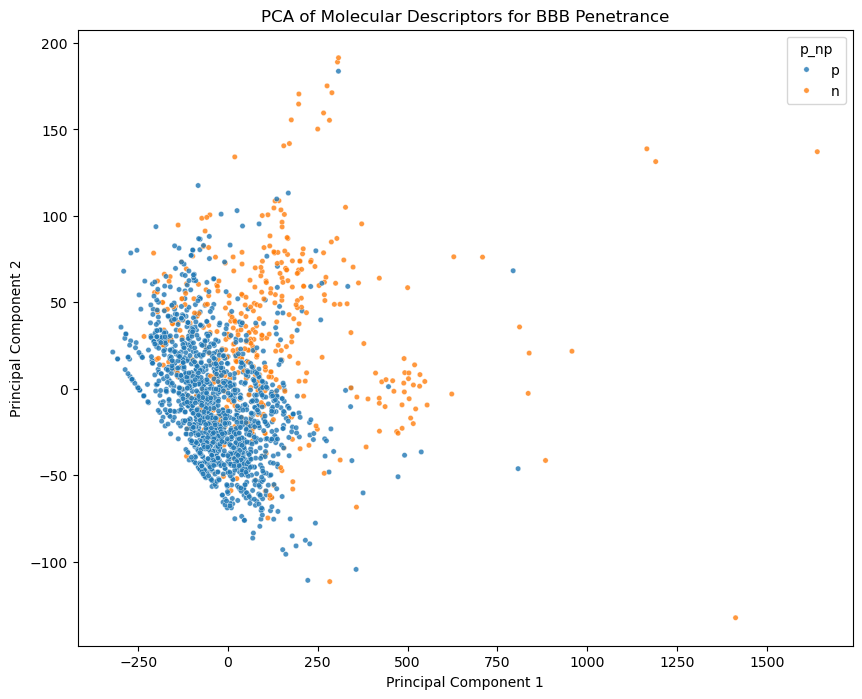

In [6]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# drop NA values from the bbb data
bbb = bbb.dropna()

# Extract relevant molecular descriptors (excluding the 'p_np' column)
Xb = bbb[["MW", "LogP", "tPSA", "HBA", "HBD"]]

# Extract the 'p_np' column to use for coloring points
yb = bbb['p_np']

# Perform PCA
n_components = 2  # the number of components to visualize
pca = PCA(n_components=n_components)
Xb_pca = pca.fit_transform(Xb)

# Create a new DataFrame with PCA components and 'p_np' labels
bbb_pca_df = pd.DataFrame(data={'PC1': Xb_pca[:, 0], 'PC2': Xb_pca[:, 1], 'p_np': yb})

# Create a scatter plot of the PCA components, coloring points based on 'p_np'
color_map = {'np': 'red', 'p': 'blue'}
plt.figure(figsize=(10, 8))
sns.scatterplot(data=bbb_pca_df, x='PC1', y='PC2', hue='p_np', s=15, alpha=0.8)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Molecular Descriptors for BBB Penetrance')
plt.show()

There is considerable overlap between "n" and "p" compounds as visualized with PCA. Perhaps t-SNE will be more effective.

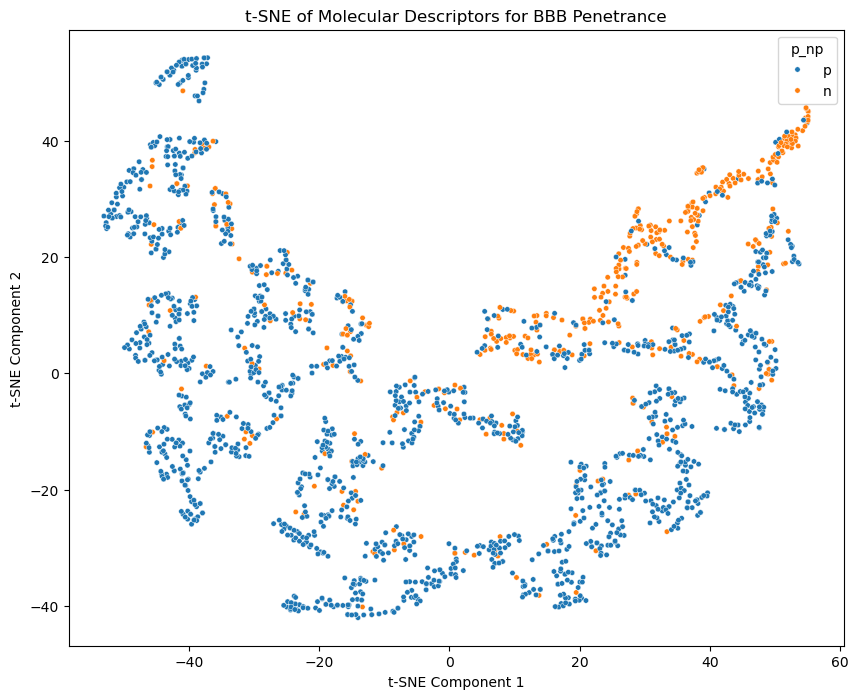

In [7]:
from sklearn.manifold import TSNE

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
Xb_tsne = tsne.fit_transform(Xb)

# Create a new DataFrame with t-SNE components and 'p_np' labels
bbb_tsne_df = pd.DataFrame(data={'t-SNE 1': Xb_tsne[:, 0], 't-SNE 2': Xb_tsne[:, 1], 'p_np': yb})

# Create a scatter plot of the t-SNE components, coloring points based on 'p_np'
plt.figure(figsize=(10, 8))
sns.scatterplot(data=bbb_tsne_df, x='t-SNE 1', y='t-SNE 2', hue='p_np', s=15)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of Molecular Descriptors for BBB Penetrance')
#handles, labels = plt.gca().get_legend_handles_labels()
#plt.legend(title='BBB Penetration', handles=handles, labels=['n', 'p'])
plt.show()

There is still quite a bit of overlap, though there seem to be more distinct clusters in the t-SNE plot.

### b) Property space of the target ligands (how are they similar or different)

Calculate summary statistics for the same molecular descriptors as above for the melatonin dataset.

In [8]:
mel[["MW", "LogP", "tPSA", "HBA", "HBD"]].describe()

,MW,LogP,tPSA,HBA,HBD
count,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000
mean,316.534934,3.169769,54.648482,3.146603,1.387763
std,87.623765,1.266826,21.264443,1.426094,0.735632
min,153.078979,-3.879100,12.470000,1.000000,0.000000
25%,257.152812,2.164000,41.990000,2.000000,1.000000
50%,297.088019,3.082320,51.470000,3.000000,1.000000
75%,349.204179,3.842000,62.300000,4.000000,2.000000
max,926.320844,8.048200,303.010000,21.000000,11.000000


Now add the melatonin data to the p/np boxplots.

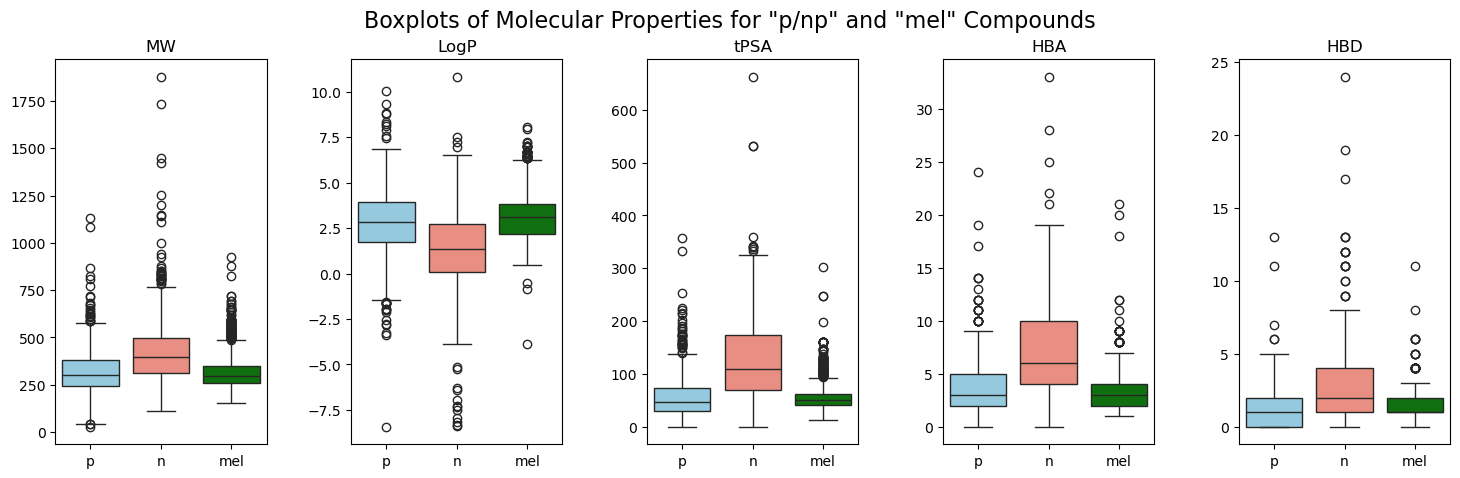

In [9]:
# Concatenate the "bbb" and "mel" DataFrames
mel['p_np'] = 'mel'
combined_data = pd.concat([bbb, mel])

# List of columns for which you want boxplots
columns_of_interest = ["MW", "LogP", "tPSA", "HBA", "HBD"]

# Create subplots for combined boxplots
fig, axes = plt.subplots(1, len(columns_of_interest), figsize=(18, 5))
fig.subplots_adjust(wspace=0.4)

# Create combined boxplots using 'hue' parameter
for i, col in enumerate(columns_of_interest):
    sns.boxplot(x='p_np', y=col, data=combined_data, ax=axes[i], hue='p_np',palette=['skyblue', 'salmon', 'green'])
    axes[i].set_title(f'{col}')
    axes[i].xaxis.set_label_text('')
    axes[i].yaxis.set_label_text('')

# Add an overall title
plt.suptitle('Boxplots of Molecular Properties for "p/np" and "mel" Compounds', fontsize=16)

# Show the plot
plt.show()

The chemical properties of the melatonin receptor ligands seem to be more similar to the BBB-penetrating compounds than to the non-penetrating compounds.

### c) Are any in both sets?

In [10]:
mel.head()

,Molecule ChEMBL ID,Molecule Name,Smiles,MW,LogP,tPSA,HBA,HBD,FractionCSP3,NumRotatableBonds,NumAromaticRings,p_np
0,CHEMBL563847,NaN,COc1ccc2[nH]c(CN(C)c3ccc(C(F)(F)F)cc3)c(CCNC(C...,419.182062,4.5103,57.36,3.0,2.0,7.0,0.318182,3.0,mel
1,CHEMBL556908,NaN,CCCC(=O)NCCc1c2n(c3ccc(OC)cc13)CCN(C)C2,329.210327,2.5541,46.50,4.0,1.0,6.0,0.526316,2.0,mel
2,CHEMBL286814,NaN,COc1cccc2[nH]cc(CCNC(C)=O)c12,232.121178,1.8551,54.12,2.0,2.0,4.0,0.307692,2.0,mel
3,CHEMBL287339,NaN,O=C(NCCc1c(Br)[nH]c2ccccc12)C1CCC1,320.052425,3.3892,44.89,1.0,2.0,4.0,0.400000,2.0,mel
4,CHEMBL45,MELATONIN,COc1ccc2[nH]cc(CCNC(C)=O)c2c1,232.121178,1.8551,54.12,2.0,2.0,4.0,0.307692,2.0,mel


In [11]:
# Check if there are any common SMILES in both DataFrames
common_compounds = bbb['smiles'].isin(mel['Smiles'])

# Extract the common compounds from the "mel" DataFrame
bbb[common_compounds]

,name,p_np,smiles,MW,LogP,tPSA,HBA,HBD,FractionCSP3,NumRotatableBonds,NumAromaticRings
206,dopamine,n,NCCc1ccc(O)c(O)c1,153.078979,0.599,66.48,3.0,3.0,2.0,0.25,1.0


Only dopamine is common to both datasets. Additionally:

In [12]:
# Look at molecules with values in the "Molecule Name" column and make sure the SMILES match
mel[['Molecule Name', 'Smiles']].dropna()

,Molecule Name,Smiles
4,MELATONIN,COc1ccc2[nH]cc(CCNC(C)=O)c2c1
21,MELATONIN,COc1ccc2[nH]cc(CCNC(C)=O)c2c1
44,AGOMELATINE,COc1ccc2cccc(CCNC(C)=O)c2c1
62,5-MEO-DMT,COc1ccc2[nH]cc(CCN(C)C)c2c1
64,MELATONIN,COc1ccc2[nH]cc(CCNC(C)=O)c2c1
...,...,...
2508,BAY-7598,O=C(O)[C@H]1[C@H](Cn2nnc3ccccc3c2=O)CC[C@@H]1C...
2509,MELATONIN,COc1ccc2[nH]cc(CCNC(C)=O)c2c1
2511,MELATONIN,COc1ccc2[nH]cc(CCNC(C)=O)c2c1
2512,AGOMELATINE,COc1ccc2cccc(CCNC(C)=O)c2c1


There are many duplicate molecules in the melatonin receptor ligand dataset. To drop duplicates based on the SMILES column:

In [13]:
mel = mel.drop_duplicates(subset='Smiles')
mel[['Molecule Name', 'Smiles']]

,Molecule Name,Smiles
0,NaN,COc1ccc2[nH]c(CN(C)c3ccc(C(F)(F)F)cc3)c(CCNC(C...
1,NaN,CCCC(=O)NCCc1c2n(c3ccc(OC)cc13)CCN(C)C2
2,NaN,COc1cccc2[nH]cc(CCNC(C)=O)c12
3,NaN,O=C(NCCc1c(Br)[nH]c2ccccc12)C1CCC1
4,MELATONIN,COc1ccc2[nH]cc(CCNC(C)=O)c2c1
...,...,...
2505,NaN,COc1ccc2oc(-c3ccccc3)c(C=O)c2c1
2506,NaN,CCCOc1ccn2c(C(C)=O)cc(-c3ccccc3S(C)(=O)=O)c2c1
2508,BAY-7598,O=C(O)[C@H]1[C@H](Cn2nnc3ccccc3c2=O)CC[C@@H]1C...
2515,CIANIDANOL,Oc1cc(O)c2c(c1)O[C@H](c1ccc(O)c(O)c1)[C@@H](O)C2


### d) What properties and/or fingerprints will you use to train and test your models? Why?

When modeling BBB penetration, the choice between molecular descriptors and molecular fingerprints depends on the nature of the problem and the characteristics of the data.  Molecular descriptors are typically more interpretable and offer quantitative measures of chemical and physical properties, such as molecular weight, logP, hydrogen bond acceptors (HBA), and donors (HBD). This interpretability aids in understanding which chemical features influence BBB penetration. Models built on descriptors often possess greater transparency, enabling analysis of the contribution of individual descriptors to predictions. Additionally, descriptors have a clear scale, facilitating data scaling and preprocessing when necessary. Models trained on descriptors tend to have a smaller number of features, making them computationally efficient, especially for smaller to moderately sized datasets.

Molecular fingerprints, on the other hand, consist of binary vectors with numerous bits representing the presence or absence of specific substructures or patterns. They excel at capturing fine-grained structural information, which proves beneficial for complex modeling tasks. Being sparse representations, fingerprints are advantageous when dealing with datasets featuring a wide range of compounds and structural diversity. They are well-suited for tasks involving chemical similarity measurements or clustering compounds based on structural features. Certain machine learning algorithms, such as random forests and support vector machines, can effectively handle binary fingerprint data. However, fingerprints may need careful selection and tuning of fingerprint types (e.g., Morgan fingerprints, Daylight fingerprints) and fingerprint size. For the purposes of this project, I have elected to use molecular descriptors.

## 2. Model building

### a) Data splitting strategy

In the code below, the data is split using a stratified method. This ensures that both classes are represented proportionally in both the training and test sets. Stratified splitting helps prevent the model from being biased toward the majority class.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# create a StandardScaler instance
scaler = StandardScaler()

# Extract the feature data (descriptors) and target variable
X = bbb[['LogP', 'tPSA', 'MW', 'HBA', 'HBD']]
y = bbb['p_np']

# fit and transform the data
X_norm = scaler.fit_transform(X)

# Perform an 80/20 stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X_norm,  # Feature data
    y,  # Target variable
    test_size=0.20,  # 80% training, 20% testing
    stratify=y,  # Stratify based on the target variable
    random_state=42  # Set a random seed for reproducibility
)

### b) Use clustering to generate a 2D plot of the chemical space colored by cluster number

First, determine the optimal number of clusters for k-means clustering.

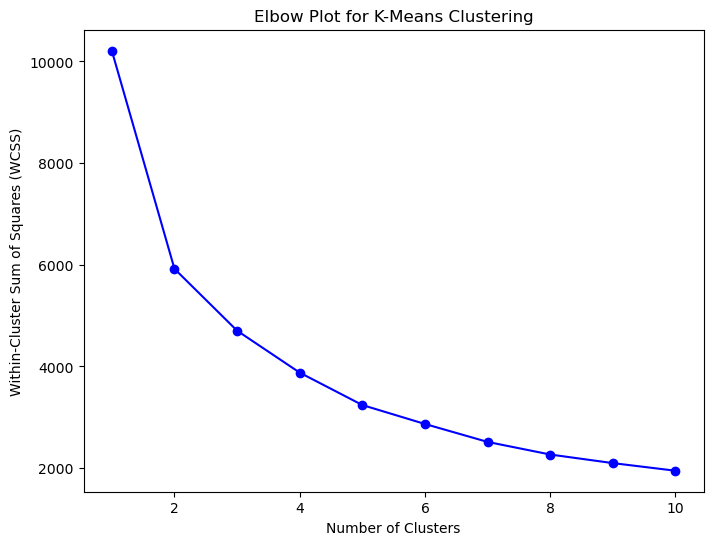

In [15]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Define a range of cluster numbers to consider (e.g., from 1 to 10 clusters)
cluster_range = range(1, 11)

# Initialize an empty list to store the within-cluster sum of squares (WCSS)
wcss = []

# Fit k-means clustering for each cluster number and calculate WCSS
for num_clusters in cluster_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init=10)
    kmeans.fit(X_norm)  # Use normalized data
    wcss.append(kmeans.inertia_)

# Create the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Plot for K-Means Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.show()

It's hard to tell on the elbow plot, but the "elbow point" seems to be at roughly k = 3. To verify:

In [16]:
from kneed import KneeLocator
kneedle = KneeLocator(range(1, 11), wcss, curve='convex', direction='decreasing')
elbow_point = kneedle.elbow
print(f"Elbow point at: {elbow_point}")

Elbow point at: 3


Now k-means clustering can be performed with k=3. The points in the t-SNE are colored by cluster assignment.

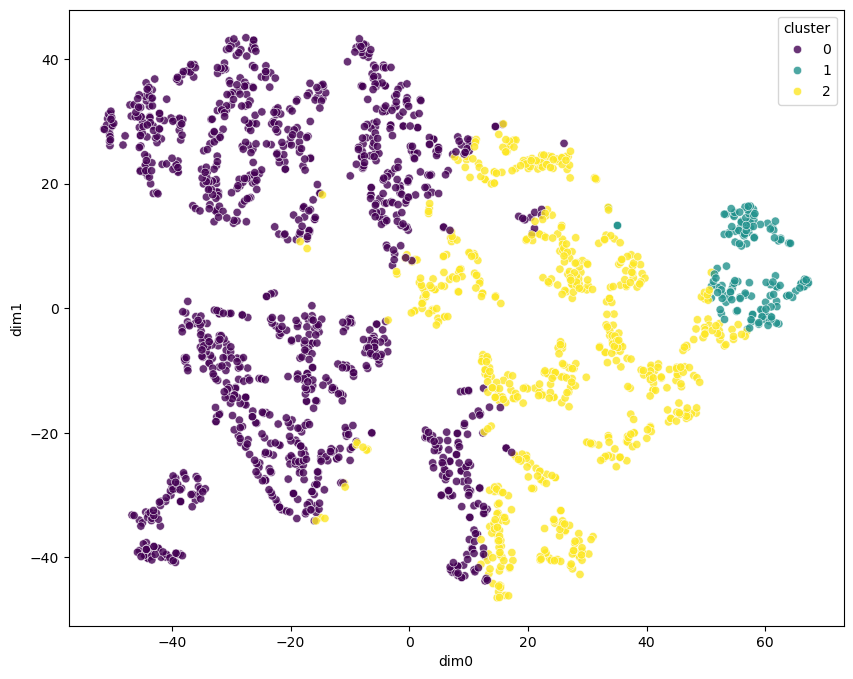

In [17]:
# perform k-means clustering with k = 3
kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)
kmeans.fit(X_norm)

# Perform dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_result = tsne.fit_transform(X_norm)

# Create a new DataFrame for the reduced data and add the cluster assignments
rd = pd.DataFrame(data=tsne_result, columns=['dim0', 'dim1'])
rd['cluster'] = kmeans.fit_predict(X_norm)

# Create a scatter plot colored by clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='dim0', y='dim1', hue='cluster', data=rd, palette='viridis', legend='full', alpha=0.8);

### c) Model validation

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create the Random Forest Classifier
# start with n_estimators = 100
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Use the trained classifier to make predictions on the test data
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Print a classification report for additional metrics
print(classification_report(y_test, y_pred))

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix, "\n")

# If you want to analyze feature importance, you can do so using the following code:
feature_importance = clf.feature_importances_
for i, importance in enumerate(feature_importance):
    print(f'{X.columns[i]} importance: {importance:.2f}')

Accuracy: 0.86
              precision    recall  f1-score   support

           n       0.71      0.68      0.70        96
           p       0.90      0.92      0.91       313

    accuracy                           0.86       409
   macro avg       0.81      0.80      0.80       409
weighted avg       0.86      0.86      0.86       409

Confusion Matrix:
[[ 65  31]
 [ 26 287]] 

LogP importance: 0.21
tPSA importance: 0.33
MW importance: 0.20
HBA importance: 0.11
HBD importance: 0.14


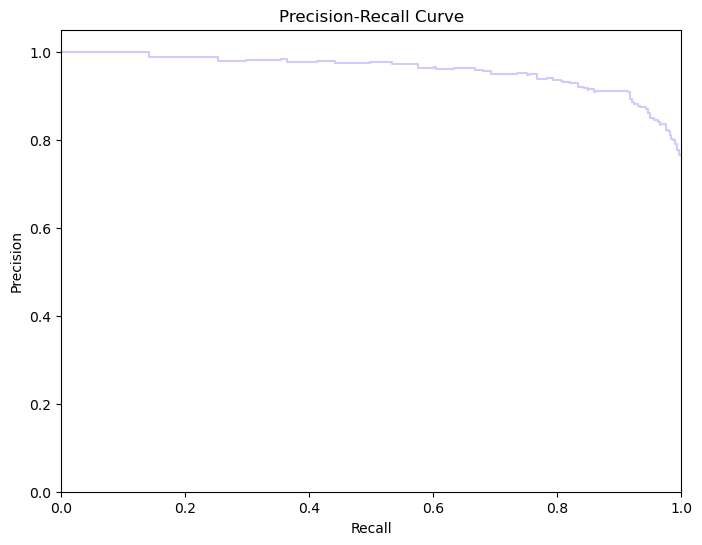

In [19]:
from sklearn.metrics import precision_recall_curve, auc

# Map 'n' to 0 and 'p' to 1
y_test_binary = [0 if label == 'n' else 1 for label in y_test]

# Predict probabilities for the positive class (class 1)
y_scores = clf.predict_proba(X_test)[:, 1]

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_test_binary, y_scores)

# Calculate the area under the PR curve (AUC-PR)
auc_pr = auc(recall, precision)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
#plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall Curve')
plt.show()

In [20]:
from sklearn.metrics import auc

# Calculate the AUC for the precision-recall curve
auc_pr = auc(recall, precision)

print(f"AUC-PR: {auc_pr:.2f}")

AUC-PR: 0.96


## 3. Prediction / Conclusions

### a) Predict the likelihood of BBB penetrance for the melatonin receptor ligands. Analyze the predictions and comment on a few of the case studies.

In [21]:
# Extract the feature data (descriptors) from the 'mel' DataFrame
X_mel = mel[['LogP', 'tPSA', 'MW', 'HBA', 'HBD']]

# Standardize the feature data using the same StandardScaler as above
X_mel_norm = scaler.transform(X_mel)

# Use the trained classifier to predict BBB penetration and create a new dataframe column
mel['Predicted_BBB_Penetration']  = clf.predict(X_mel_norm)

# Examine molecules with names and their predicted BBB penetration
mel[['Molecule Name', 'Predicted_BBB_Penetration']].dropna()

,Molecule Name,Predicted_BBB_Penetration
4,MELATONIN,p
44,AGOMELATINE,p
62,5-MEO-DMT,p
76,UMBELLIPRENIN,p
135,MAGNOLOL,n
150,IODOMELATONIN,p
341,LUZINDOLE,p
368,SEROTONIN,p
415,URB-597,p
538,N6022,p


Correct predictions:

- melatonin 
- agomelatine
- 5-MeO-DMT
- umbelliprenin (https://doi.org/10.1016/j.neulet.2015.06.016)
- iodomelatonin
- luzindole
- serotonin (https://doi.org/10.1016/j.febslet.2015.05.054)
- URB-597 (an FAAH inhibitor: https://doi.org/10.1089/can.2021.0237)
- acetylserotonin
- ramelteon
- dopamine (https://doi.org/10.3389/fncel.2022.944243)

Incorrect predictions: 
- magnolol (https://doi.org/10.2174/1874467215666220223141101) (False negative)
- cianidanol (https://doi.org/10.1016/j.bbrep.2016.12.012) (False negative)

No data on BBB penetration:
- N6022
- TP-030n (RIPK1 probe)
- BI-9627 (NHE1 inhibitor)
 
It's somewhat challenging to assess the accuracy of the trained algorithm when there is little available data on the blood brain barrier penetration of even the named compounds in the dataset. For the limited number of compounds for which I was able to find conclusive information, there are more correct than incorrect predictions.

### b) Find a chemical space (e.g. use previous weeks chemical sets, or find your own on ChemBl - for example use results from your VS from week 6) and predict BBB penetrance using your model. Does this seem to make sense? What were your prior assumptions?

First load the ZINC library from Week 6.

In [36]:
# load the zinc library (converted from SDF to SMILES in week 6)
lib = pd.read_csv("/Users/jennyflax/RBIF110/Week6-VirtualLibrary.txt", sep="\t", header=None)
lib.rename(columns={0:"name", 1: "smiles"}, inplace=True)

lib['zinc_id'] = lib['name'].str.extract(r'ZINC0*(\d+)')
lib.drop("name", axis=1, inplace=True)
lib.head()

,smiles,zinc_id
0,CCCCCCN1C(=O)NC(=O)/C(=C\N/N=c2\[nH]c3c(c(=O)n...,9160514
1,N#Cc1ccc(C[N@@H+]2CCOC[C@]3(CC(=O)N(c4ccc(F)cc...,585104165
2,NC(=O)/C=C(\N)[NH2+]Nc1cc(Cl)ccc1[N+](=O)[O-],16385159
3,Nc1nc2c(c(=O)[nH]1)N[C@@H](CCNc1ccc(C(=O)O)cc1...,8664075
4,COc1ccc([C@@H](O)C(=O)c2nc3ccc([N+](=O)[O-])cc...,17223674


Calculate molecular descriptors:

In [37]:
# calculate molecular descriptors

lib[["MW", "LogP", "tPSA", "HBA", "HBD"]] = lib["smiles"].apply(lambda x: pd.Series(calculate_descriptors(x)))
lib.head()

[10:02:41] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry


,smiles,zinc_id,MW,LogP,tPSA,HBA,HBD
0,CCCCCCN1C(=O)NC(=O)/C(=C\N/N=c2\[nH]c3c(c(=O)n...,9160514,446.202616,-1.14830,155.59,10.0,3.0
1,N#Cc1ccc(C[N@@H+]2CCOC[C@]3(CC(=O)N(c4ccc(F)cc...,585104165,380.176882,1.53578,57.77,3.0,1.0
2,NC(=O)/C=C(\N)[NH2+]Nc1cc(Cl)ccc1[N+](=O)[O-],16385159,272.054493,-0.57610,140.89,5.0,4.0
3,Nc1nc2c(c(=O)[nH]1)N[C@@H](CCNc1ccc(C(=O)O)cc1...,8664075,330.144038,0.75850,145.16,7.0,6.0
4,COc1ccc([C@@H](O)C(=O)c2nc3ccc([N+](=O)[O-])cc...,17223674,355.080435,1.75620,135.42,7.0,2.0


Apply a PAINS filter and calculate summary statistics for the filtered data:

In [38]:
from rdkit.Chem import AllChem
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams

# Define or import a list of PAINS substructures
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

# Function to apply PAINS filter to a SMILES string
def apply_pains_filter(smiles, catalog):
	molecule = Chem.MolFromSmiles(smiles)
	if molecule is not None:
	# Check if the molecule matches any PAINS filter entries
		matches = catalog.GetFilterMatches(molecule)
		return not bool(matches)  # Returns True if no PAINS substructure is found
	return False  # Handle invalid SMILES if any

# Apply the PAINS filter to the DataFrame
lib['pass_pains_filter'] = lib['smiles'].apply(lambda x: apply_pains_filter(x, catalog))

# Filter the DataFrame to retain only compounds that pass the PAINS filter
filtered_lib = lib[lib['pass_pains_filter']]
filtered_lib = filtered_lib.drop(columns=['pass_pains_filter'])

#get some statistics about the library
filtered_lib.describe()

[10:03:34] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry


,MW,LogP,tPSA,HBA,HBD
count,13822.000000,13822.000000,13822.00000,13822.000000,13822.000000
mean,359.251062,0.705559,103.53025,5.836420,2.074085
std,54.397212,1.644398,36.27983,2.014547,1.445639
min,248.909526,-7.557100,9.23000,0.000000,0.000000
25%,317.057329,-0.403800,77.30250,4.000000,1.000000
50%,358.158374,0.904590,100.67000,6.000000,2.000000
75%,405.104419,2.047305,125.17000,7.000000,3.000000
max,676.351923,6.352920,323.68000,16.000000,11.000000


The filtered library is over 13,800 compounds, so take a smaller random sample to predict BBB penetrance:

In [39]:
# take a random subsample of the filtered library
lib_sub = pd.DataFrame(filtered_lib)
lib_sub = lib_sub.sample(1500)

# Extract the feature data from the random sample
X_lib = lib_sub[['LogP', 'tPSA', 'MW', 'HBA', 'HBD']]

# Standardize the feature data using the same StandardScaler as above
X_lib_norm = scaler.transform(X_lib)

# Use the trained classifier to predict BBB penetration and create a new dataframe column
lib_sub['Predicted_BBB_Penetration']  = clf.predict(X_lib_norm)

# Examine molecules with names and their predicted BBB penetration
lib_sub.head()

,smiles,zinc_id,MW,LogP,tPSA,HBA,HBD,Predicted_BBB_Penetration
8432,O=[N+]([O-])c1ccccc1S(=O)(=O)NCCC[NH+]1CCCCCC1,13668925,342.148204,0.7221,93.75,4.0,2.0,p
5956,CC(=O)NCCC(=O)N1C[C@@H]2C[C@@H](O)C[N@@H+]2C2(...,514289133,311.207767,-2.9429,77.32,4.0,3.0,p
3892,Nc1nnnn1CC(=O)N1CC[N@@H+](C2CCOCC2)C[C@@H](O)C1,97637955,326.193514,-3.4777,123.83,8.0,3.0,n
11115,CC(=O)N[C@@H]([C@H](O)[C@H](O)[C@H](O)CO)[C@H]...,4523370,309.105981,-4.0292,184.62,8.0,7.0,n
3169,NC(=O)c1ccc(S(=O)(=O)NCCC(=O)O)cc1,37415033,272.046692,-0.4615,126.56,4.0,3.0,p


Now draw the compounds and display their corresponding predictions.

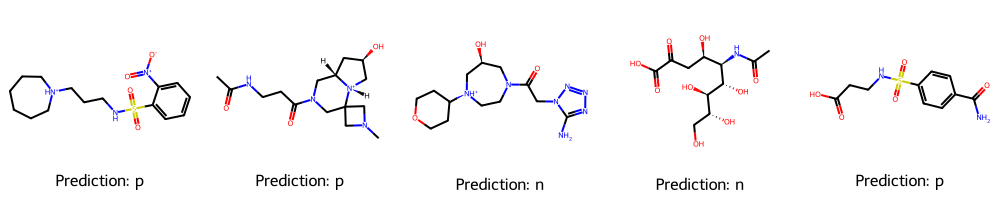

In [42]:
from IPython.display import display
from rdkit.Chem import Draw

# get the first 5 SMILES from the above dataframe
molecules = [Chem.MolFromSmiles(smiles) for smiles in lib_sub['smiles'][:5]]

# Draw the chemical structures
labels = [f"Prediction: {prediction}" for prediction in lib_sub['Predicted_BBB_Penetration'][:5]]
img = Draw.MolsToGridImage(molecules, molsPerRow=5, legends=labels)

# Display the image
display(img)

Compounds 1 and 2, predicted to penetrate the BBB (p), have features generally favorable for BBB penetration, with Compound 1 having a positive LogP and moderate tPSA and Compound 2 having a higher HBD count. These attributes are consistent with the observed predictions. Compound 5, also predicted as permeable (p), has a lower LogP and higher tPSA, which are not typically associated with BBB penetration, suggesting that other factors may be influencing its predicted permeability.

In contrast, Compound 3, which is predicted not to penetrate the BBB (n), has a very low LogP and a high tPSA, aligning with its non-penetrative prediction. Compound 4, with a similarly low LogP and the highest tPSA of the group, is also predicted as non-penetrable (n), which corresponds to the typical expectations for such molecular characteristics.

Overall, the predicted BBB penetration for these compounds mostly aligns with their molecular descriptors, yet experimental validation is essential to confirm these predictions.